In [1]:
%load_ext autoreload
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_trimers_line(f, l, stride=1):
    pocket.height = l
    pocket.width = l
    with open(f, "r") as f:
        for index, l in enumerate(f.readlines()):
            if index % stride == 0:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_monomers_line(f, l, stride=1):
    pocket.height = l
    pocket.width = l
    with open(f, "r") as f:
        for index, l in enumerate(f.readlines()):
            if index % stride == 0:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_monomers_cut(f, l, stride=1):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride):
        for i in range(len(pos)):
            for j in range(len(pos)):
                d = pocket.center_mono((0, 0), (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1]))
                if d[0] == 0:
                    vals[d[1]] += 1
    return vals

def read_trimers_cut(f, l, stride=1):
    pocket.height = l
    pocket.width = l
    r = []
    n = 0
    with open(f, "r") as f:
        for index, line in enumerate(f.readlines()):
            if index % stride == 0:
                arr = np.zeros((l//2,))
                n += 1
                for i, v in enumerate(line.split()):
                    arr[i] += float(v)
                r.append(arr)
    return np.array(r)

def autocorr(vals, label=None):
    bvar = np.var(vals, ddof=1)
    xs = [4, 8, 16, 32, 64, 128, 256, 400, 512, 700, 1024, 1500, 2048, 4096, 8000, 16000]
    ys = []
    for bsize in xs:
        bmeans = [np.mean(vals[bsize*i:bsize*(i+1)]) for i in range(len(vals)//bsize)]
        ys.append(np.var(bmeans, ddof=1) * bsize / bvar)

    plt.plot(xs, ys, label=label)

In [5]:
pos = list(read_trimers_line("data/102x102-3-1000-trimers.dat", 102))

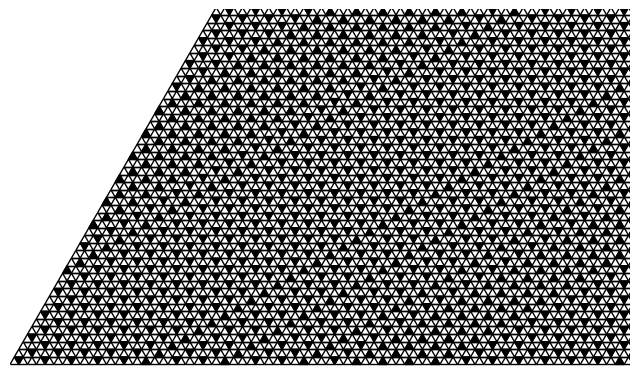

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[998], None), wf="tri", color="black", zoom=0.4)

In [ ]:
x = read_trimers_cut("data/42x42-3-2000000-trimers-cut2.dat", 42)

In [ ]:
autocorr(x[:50000, -1], label="50K")
autocorr(x[:200000, -1], label="200K")
autocorr(x[:, -1], label="2M")
autocorr(x[50000:100000, -1], label="50K-t")
autocorr(x[50000:250000, -1], label="200K-t")
autocorr(x[50000:, -1], label="2M-t")
plt.legend()
plt.yscale("log")

In [ ]:
x = read_trimers_cut("data/30x30-3-500000-trimers-cut3.dat", 30)

In [ ]:
autocorr(x[:50000, -1], label="50K")
autocorr(x[:200000, -1], label="200K")
autocorr(x[:, -1], label="2M")
autocorr(x[10000:60000, -1], label="50K-t")
autocorr(x[10000:210000, -1], label="200K-t")
autocorr(x[10000:, -1], label="2M-t")
plt.legend()

In [ ]:
x1 = read_trimers_cut("data/30x30-3-500000-trimers-cut.dat", 30)
x2 = read_trimers_cut("data/30x30-3-500000-trimers-cut3.dat", 30)

In [15]:
x3 = read_trimers_cut("data/108x108-3-5000000-trimers-cut.dat", 108)
x4 = read_trimers_cut("data/102x102-3-500000-trimers-cut.dat", 102)

[-2.0585397  -0.07827349  0.16537478]


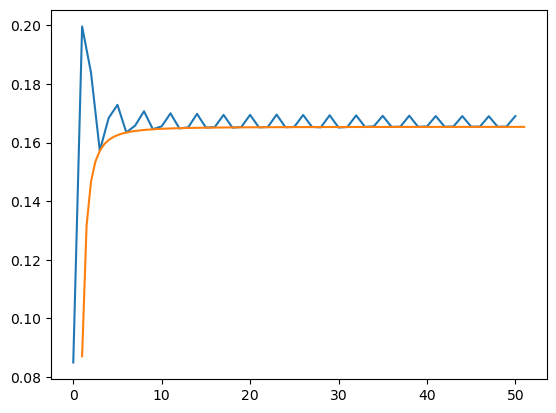

In [27]:
x = x4
start = 200000
end = -1
stride = 10
xs = (np.arange(x.shape[1]))[3::3]
import scipy
plt.plot(x[start:end:stride].mean(axis=0))
def fit(x, A, B, C):
    return B * np.power(x, A) + C
P, _ = scipy.optimize.curve_fit(fit, xs, x[start:end:stride, 3::3].mean(axis=0), p0=[-2, 1, 0.1])
plt.plot(np.linspace(1, x.shape[1], 100), fit(np.linspace(1, x.shape[1], 100), *P))
print(P)

In [ ]:
avgs = []
xs = np.arange(6, 90, 6)
for i in xs:
    pocket.width = i
    pocket.height = i
    mono = read_monomers(f"data/{i}x{i}-3-500000-monomers.dat", (i//2-1, 0))
    avgs.append(np.mean(mono))

In [ ]:
factor = (xs/3)**2

import scipy
def fit(x, A, B):
    return B * np.power(x, A)
P, _ = scipy.optimize.curve_fit(fit, xs, np.array(avgs)*factor)
plt.plot(np.linspace(6, 90, 100), fit(np.linspace(6, 90, 100), *P), label=f"powerlaw with exp {P[0]:.3f}")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.xlabel("$\\overline{r}$")
plt.plot(xs, np.array(avgs)*factor)

In [ ]:
xs = np.arange(6, 109, 6)
vals = []
for i in xs:
    pocket.width = i
    pocket.height = i
    L = i
    d = read_monomers_line(f"data/{i}x{i}-3-500000-monomers.dat", 1)
    dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
    dk = np.arange(min(d.keys()), max(d.keys()) + 1)
    for key, value in sorted(d.items()):
        dn[key-min(d.keys())] = value

    dn[len(dn)//2] = 0
    dk = np.sin(np.pi/L * dk) / (np.pi/L)

    import scipy
    def fit(x, A, B):
        return B * np.power(np.abs(x), A)

    crit = np.logical_and(dn>0, dk>0)
    P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])
    vals.append(P[0])
    # print(P)

    # plt.plot(dk, dn)
    # plt.plot(dk, fit(dk, *P))

In [ ]:
plt.plot(xs, vals + [0])

In [ ]:
vals = read_monomers("data/102x102-3-500000-monomers.dat", (18-1,0))

In [ ]:
autocorr(vals)

In [ ]:
vals = np.arange(6, 108, 6)
amps = []
for i in vals:
    pocket.width = i
    pocket.height = i
    x = read_trimers(f"data/{i}x{i}-3-500000-trimers-cut.dat", i, 1)
    amp = max(x[-6:]) - min(x[-6:])
    amps.append(amp)


In [ ]:
plt.plot(vals, amps)
plt.xlabel("L")
plt.ylabel("envleope size")